In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
import re

import collections
import seaborn as sns

In [134]:
#한글 깨짐 처리
import os

if os.name == 'posix':
    plt.rc("font", family="AppleGothic")

else :
    plt.rc("font", family="Malgun Gothic")

%config InlineBackend.figure_format = 'retina'

In [4]:
train = pd.read_csv("capstone_dataset/train.csv")
val = pd.read_csv("capstone_dataset/valid.csv")
test = pd.read_csv("capstone_dataset/test.csv")

In [5]:
train.head()

,id,title,body,category,label
0,AKR20191006026700004,공소시효 만료로 수배 해제 5년간 2만3천건…하루 13건꼴,공소시효가 만료돼 수배가 해제되는 사건이 하루 12∼13건꼴인 것으로 조사됐다. 6...,3,0
1,AKR20190201116900051,설 연휴 부산 병·의원 2천75곳 문 연다,이번 설 연휴 부산에서는 모두 2천75곳의 병·의원이 문을 연다. 부산시는 2일부터...,3,0
2,AKR20200731075300061,"시흥시, 청년근로자 100명에 60만원씩 복지포인트 지급","경기 시흥시는 관내 시흥청년해피기업에 근무하는 청년 근로자 100명을 선정, 1인당...",7,0
3,AKR20191220114000001,"한국당 5일째 패스트트랙法 규탄대회…""4+1, 文정권에 예산뇌물""",자유한국당 황교안 대표와 민주평화당 정동영·정의당 이정미 대표는 4일 상견례 자리에...,1,1
4,AKR20191029112900057,"울산시의원 ""시민 참여 온라인 쇼핑몰 울산몰 만들자""",경남도의회는 11일 제10호 태풍 하이선으로 낙과 피해를 본 밀양시 산내면 사과 재...,1,1


# preprocessing

In [6]:
def preprocessing(text):
    m = Mecab()
    
    cleaned_text = re.sub('[^가-힣]', ' ', text) #한글과 영어 소문자만 남기고 다른 글자 모두 제거
    tokenized_text = m.morphs(cleaned_text)
    removed_by_len_text = [token for token in tokenized_text if len(token)>1]
    return removed_by_len_text

In [7]:
train['title_token'] = train['title'].apply(preprocessing)
train['body_token'] = train['body'].apply(preprocessing)

val['title_token'] = val['title'].apply(preprocessing)
val['body_token'] = val['body'].apply(preprocessing)

In [8]:
#train['token'] = tokenized_data

body의 최대 길이 : 3232
body의 평균 길이 : 181.94978


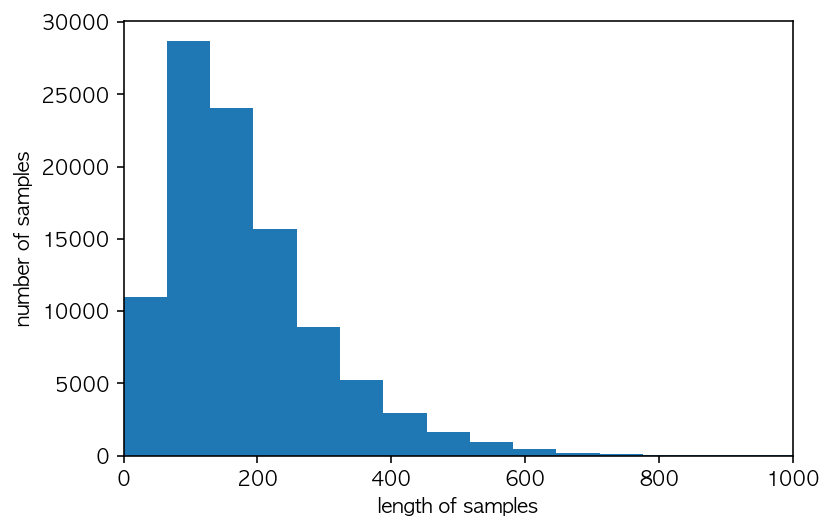

In [9]:
# body 길이 분포 확인
print('body의 최대 길이 :',max(len(review) for review in train['body_token']))
print('body의 평균 길이 :',sum(map(len, train['body_token']))/len(train['body_token']))
plt.hist([len(body) for body in train['body_token']], bins=50)
plt.xlim(0,1000)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
tokenizer = Tokenizer() 
tokenized_text = pd.concat([train.body_token,train.title_token],axis=0)
tokenizer.fit_on_texts(tokenized_text)
vocab_size = len(tokenizer.word_index) + 1 # 패딩을 고려하여 +1

In [38]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
vocab_size

127860

In [15]:
def encoded_text(tokenizer,tokenized_data,max_len):
    encoded = tokenizer.texts_to_sequences(tokenized_data)
    padded = pad_sequences(encoded, maxlen=max_len)
    return padded

In [16]:
train_encoded_title_text = encoded_text(tokenizer,train['title_token'],10)
train_encoded_body_text = encoded_text(tokenizer,train['body_token'],415)

val_encoded_title_text = encoded_text(tokenizer,val['title_token'],10)
val_encoded_body_text = encoded_text(tokenizer,val['body_token'],415)

# FastText

In [17]:
import gensim
from gensim import models
from gensim.models import fasttext
from gensim.models.fasttext import FastText
from gensim.models import Word2Vec, KeyedVectors

In [ ]:
#load embedding model
ft_model = FastText.load("/Users/saeran/Desktop/SJU2022/캡스톤/final/fasttext_final.bin")

In [45]:
#ft_model = fasttext.load_facebook_model('/Users/saeran/Desktop/SJU2022/캡스톤/wordembedding/fasttext_wiki.ko/wiki.ko.bin')
#ft_model.build_vocab(sentences=tokenized_text, update=True)
#ft_model.train(tokenized_text, total_examples=len(tokenized_text),epochs=5)

CPU times: user 43min 19s, sys: 22min 51s, total: 1h 6min 10s
Wall time: 1h 16min 53s


In [47]:
embedding_matrix = np.zeros((vocab_size, 300)) #300차원의 임베딩 매트릭스 생성

for word,index in tokenizer.word_index.items(): #vocabulary에 있는 토큰들을 하나씩 넘겨줍니다.
    if word in ft_model: #넘겨 받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 뜻)
        embedding_vector = ft_model[word] #해당 토큰에 해당하는 vector를 불러오고
        embedding_matrix[index] = embedding_vector #해당 위치의 embedding_mxtrix에 저장합니다.
    else:
        print(word)
        break

<ipython-input-47-c7fdf2dd8ebc>:4: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in ft_model: #넘겨 받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 뜻)
<ipython-input-47-c7fdf2dd8ebc>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_vector = ft_model[word] #해당 토큰에 해당하는 vector를 불러오고


In [48]:
len(tokenizer.word_index)

127859

In [49]:
print(ft_model.wv.similar_by_word('병원'))

[('요양병원', 0.8426705598831177), ('입원병원', 0.8274955749511719), ('암병원', 0.825345516204834), ('시립병원', 0.8216047286987305), ('도립병원', 0.8207738995552063), ('차병원', 0.8164739608764648), ('병원원장', 0.807398796081543), ('경기요양병원', 0.8065614700317383), ('입원', 0.8056484460830688), ('응급실', 0.8020259737968445)]


In [50]:
#임베딩 모델 저장
#ft_model.save("/Users/saeran/Desktop/SJU2022/캡스톤/wordembedding/fasttext_final.bin")

# attention (바다나우)

In [51]:
import tensorflow as tf

In [111]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, values, query): # key와 value는 같음
        #1.attention score (encoder의 hidden states와 t-1 decoder의 state)
        query_expand_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(values)+self.W2(query_expand_axis))) #(batch_size, max_length, 1)

        #2.attention weights(softmax)
        attention_weights = tf.nn.softmax(score, axis=1) #(batch_size, max_length, 1)

        #3. attention value(어텐션 가중치, encoder hidden states)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# bi-LSTM + attention

In [59]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras import Input, Model,layers
from tensorflow.keras import optimizers
from keras.layers import Dense, Embedding, LSTM, Concatenate, Dropout, Bidirectional, Attention

In [54]:
X_train_title, X_val_title = train_encoded_title_text, val_encoded_title_text
X_train_body, X_val_body = train_encoded_body_text, val_encoded_body_text
y_train, y_val = train.label.values, val.label.values

In [55]:
X_train_title.shape, X_val_title.shape,X_train_body.shape,X_val_body.shape, y_train.shape, y_val.shape

((100000, 10), (25000, 10), (100000, 415), (25000, 415), (100000,), (25000,))

In [56]:
X_train_title.shape, X_val_title.shape

((100000, 10), (25000, 10))

In [57]:
embedding_matrix.shape

(127860, 300)

In [63]:
#bi-lstm + attention

#title : bi - lstm
input_title = Input(shape=(10,),name="title",dtype='int32')
embedded_title = Embedding(vocab_size,300,weights = [embedding_matrix], input_length = 10,trainable=False)(input_title)
lstm_title = Bidirectional(LSTM(64, dropout=0.2))(embedded_title)
#body: bi-lstm + attention
input_body = Input(shape=(415,),name="body",dtype='int32')
embedded_body = Embedding(vocab_size, 300,weights = [embedding_matrix], input_length = 415,trainable=False)(input_body)
#lstm_body = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_body)
lstm_body, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(embedded_body)

state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

attention = BahdanauAttention(64) #바다나우어텐션
score, context_vector, attention_weights = attention(lstm_body, state_h) 

#title + body
concatenated = layers.concatenate([lstm_title,context_vector]) 

#layer
layer1 = Dense(512,activation='relu')(concatenated)
layer2 = Dense(256,activation='relu')(layer1)

#분류
output = Dense(1, activation='sigmoid')(layer2)

model = Model(inputs=[input_title,input_body],outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 body (InputLayer)              [(None, 415)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 415, 300)     38358000    ['body[0][0]']                   
                                                                                                  
 title (InputLayer)             [(None, 10)]         0           []                               
                                                                                                  
 bidirectional_7 (Bidirectional  [(None, 415, 128),  186880      ['embedding_7[0][0]']            
 )                               (None, 64),                                                

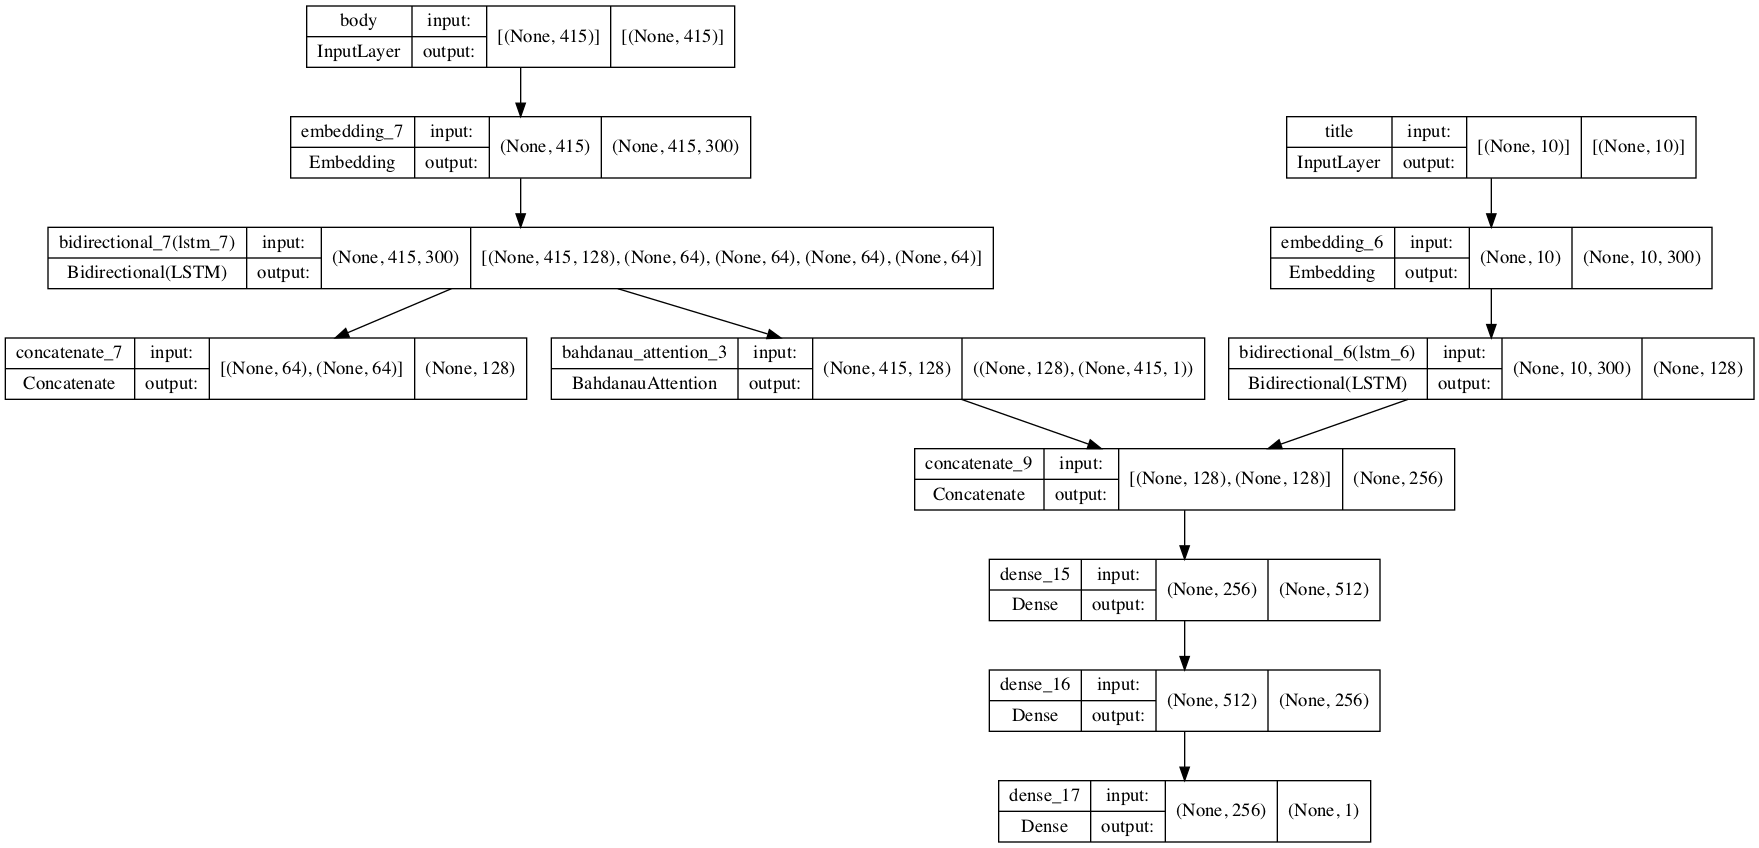

In [72]:
#model structure visualization
from tensorflow import keras
from tensorflow.keras.utils import plot_model
keras.utils.plot_model(model,show_shapes=True)

In [73]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit({'title':X_train_title,'body':X_train_body}, y_train, epochs=10, batch_size=256, verbose=1,callbacks=[es],validation_data=[[X_val_title,X_val_body],y_val])

Epoch 1/10
391/391 [==============================] - 694s 2s/step - loss: 0.5576 - acc: 0.6859 - val_loss: 0.4052 - val_acc: 0.8211
Epoch 2/10
391/391 [==============================] - 675s 2s/step - loss: 0.3439 - acc: 0.8503 - val_loss: 0.3172 - val_acc: 0.8649
Epoch 3/10
391/391 [==============================] - 753s 2s/step - loss: 0.2520 - acc: 0.8959 - val_loss: 0.2583 - val_acc: 0.8952
Epoch 4/10
391/391 [==============================] - 795s 2s/step - loss: 0.2132 - acc: 0.9141 - val_loss: 0.2375 - val_acc: 0.9022
Epoch 5/10
391/391 [==============================] - 741s 2s/step - loss: 0.1900 - acc: 0.9241 - val_loss: 0.2129 - val_acc: 0.9145
Epoch 6/10
391/391 [==============================] - 697s 2s/step - loss: 0.1704 - acc: 0.9329 - val_loss: 0.1906 - val_acc: 0.9259
Epoch 7/10
391/391 [==============================] - 1361s 3s/step - loss: 0.1572 - acc: 0.9385 - val_loss: 0.2021 - val_acc: 0.9207
Epoch 8/10
391/391 [==============================] - 731s 2s/step -

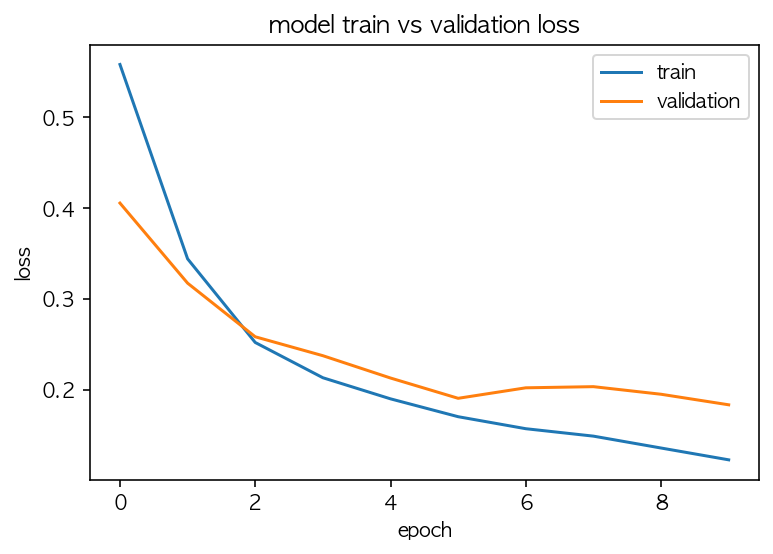

In [74]:
#Diagnostic Plots
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
pd.DataFrame(history.history)

In [ ]:
#Diagnostic Plots
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
#정성적 평가
#prediction = model.predict([X_val_title,X_val_body])
#result = val.copy() #깊은 복사
#result['prediction_CNN']=prediction 
#result.to_csv('result_실험제목.csv')

In [ ]:
model.save("model_final_mine.h5")

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [70]:
%%time
loaded_model = FastText.load("/Users/saeran/Desktop/SJU2022/캡스톤/final/wordembedding/fasttext_final.bin")

CPU times: user 5.5 s, sys: 20.7 s, total: 26.2 s
Wall time: 38.3 s


In [198]:
sample_title = '1분기 전국 건축 인허가·착공·준공 물량 일제히 증가'
sample_body = '올해 1분기(1∼3월) 전국의 건축 인허가, 착공, 준공 물량이 모두 작년 같은 기간보다 줄어든 것으로 나타났다. 3일 국토교통부 통계에 따르면 1분기에 인허가된 건축물은 4만6천435동으로 작년 1분기보다 9.8% 감소했다. 다만 면적 기준으로 보면 전국의 인허가 면적은 4천75만1천㎡로, 작년 동기 대비 11.6% 증가했다. 지역별 인허가 건축물은 수도권(1만6천728동)의 경우 9.3% 감소했고, 지방(2만9천707동)은 19.4% 줄었다. 용도별로는 농수산 등 기타(-29.9%)를 비롯해 주거용(-8.9%), 공업용(-6.2%), 교육 및 사회용(-4.6%), 상업용(-0.8%) 등 모든 용도의 건축 인허가 물량이 축소됐다. 전국의 1분기 착공 물량은 작년 1분기보다 14.4% 적은 3만4천726동에 그쳤다. 감소율은 수도권(1만1천422동)이 13.2%, 지방(2만3천304동)이 15.0%로 집계됐다. 같은 기간 준공된 전국 건축물은 총 3만5천716동이고, 연면적으로는 총 2만6천372만㎡다. 이는 작년 동기와 비교해 건축물 기준으로 7.7%, 면적 기준으로는 16.4% 각각 적은 것이다. 수도권(1천387만9천㎡)의 준공 면적은 1년새 11.4% 감소했고, 지방(1천249만3천㎡)은 21.4% 줄었다. 건축 인허가, 착공, 준공 통계는 건축행정시스템(https://cloud.eais.go.kr)과 건축물생애이력관리시스템(http://blcm.go.kr)에서 확인할 수 있다.'

In [199]:
#preprocessing
preprocessed_title = preprocessing(sample_title)
preprocessed_body = preprocessing(sample_body) 

In [200]:
tokenized_title = tokenizer.texts_to_sequences([preprocessed_title])   
tokenized_body = tokenizer.texts_to_sequences([preprocessed_body])  

In [201]:
 #padding
padded_title = pad_sequences(tokenized_title, 10)
padded_body = pad_sequences(tokenized_body, 415)

In [202]:
model.predict([padded_title,padded_body])

array([[0.00191197]], dtype=float32)

In [203]:
in_to_out = Model(inputs=[input_title,input_body], outputs=[context_vector, attention_weights])

In [204]:
prediction = in_to_out.predict([padded_title,padded_body])

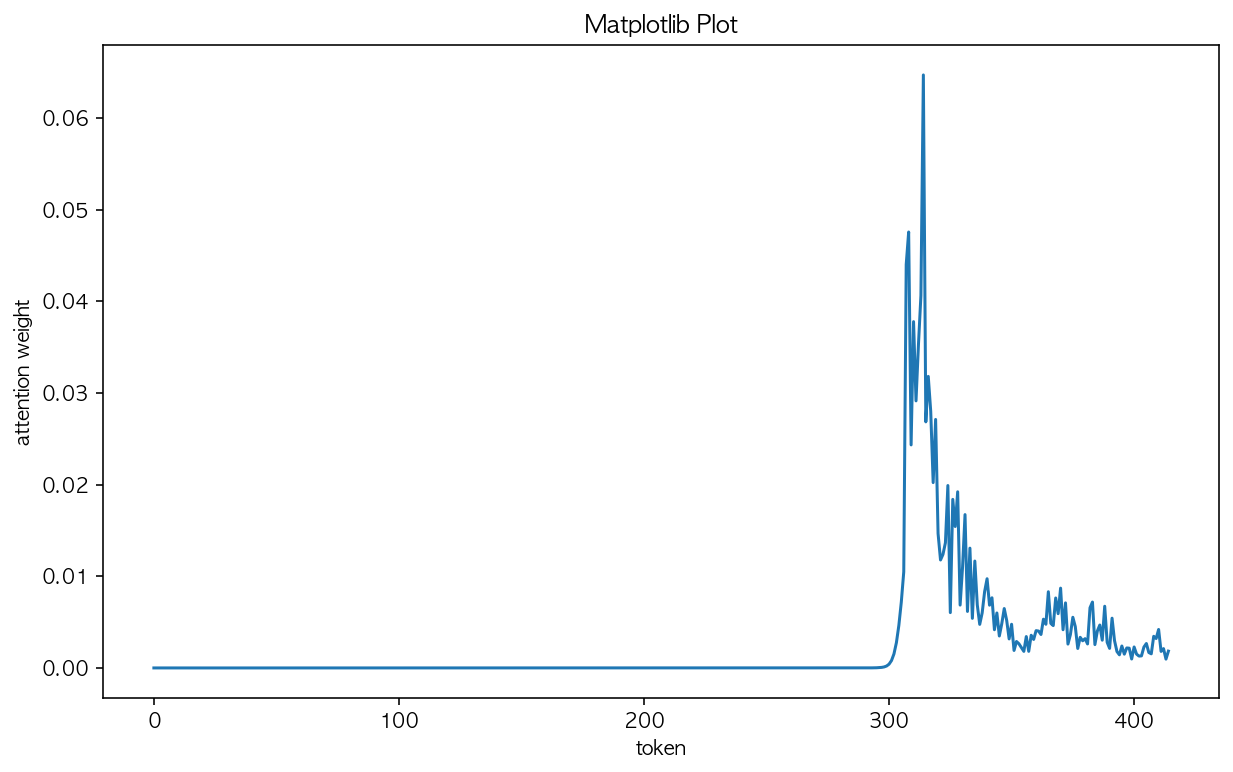

In [205]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))

x= [i for i in range(415)]
y= prediction[1][0]

#body_len = len(preprocessed_body)
#padding = ['p']*(415-body_len)
#values = padding + preprocessed_body

plt.plot(x,y)
plt.xlabel("token")
plt.ylabel("attention weight")
plt.title("Matplotlib Plot")
#plt.xticks(x,values)
plt.show()